In [1]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import spacy
import tomotopy as tp
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
from collections import Counter, OrderedDict
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, BatchNormalization, Flatten, SpatialDropout1D, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [2]:
folder = ""

# load the data
df_train = pd.read_csv(os.path.join(folder,'train.csv'))
df_test = pd.read_csv(os.path.join(folder,'test.csv'))

In [3]:
# Data Preprocessing
#-------------------
# Tokenize the sentences
nlp = spacy.load("en_core_web_sm")
# preprocessing function
def preprocessing_fn(df):
    df["list_of_lemmatized_words"] = None
    df["lemmatized_sentence"] = None
    indexes_to_drop = []  # remembering indexes to drop empty reviews
    list_of_lemmatized_words = []
    lemmatized_sentences = []
    for index, row in df.iterrows():   
        # initial cleanup of the sentences
        cleaned_text = " ".join(row["text"].replace("\n", "").replace("<s/>", "").replace("\"","").lower().split())
        
        # Lemmatization
        tmp_lms = []
        str_lms = " "
        for token in nlp(cleaned_text):
            # remove stop words, punctuations and numbers
            if not token.is_stop and not token.is_punct and not token.like_num:
                # list of lemmatized words
                tmp_lms.append(token.lemma_)
                # string of lemmatized words
                str_lms += token.lemma_ + " "
        list_of_lemmatized_words.append(tmp_lms)
        lemmatized_sentences.append(str_lms)

        # Only keep non empty reviews
        if len(tmp_lms) == 0:
            indexes_to_drop.append(index)

    df["list_of_lemmatized_words"] = list_of_lemmatized_words
    df["lemmatized_sentence"] = lemmatized_sentences

    df_clean = df.drop(index=indexes_to_drop)  # dropping empty reviews
    return df_clean

df_clean_train = preprocessing_fn(df_train)

# save df to csv
df_clean_train.to_csv(os.path.join(folder,'train_clean.csv'), index=False, header=True)


In [4]:
# load df from csv
df_clean_train = pd.read_csv(os.path.join(folder,'train_clean.csv'), header=0)

# Data splits
# -------------
# split the data into train, validation and test sets
seed1 = 42
seed2 = 52
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(df_clean_train.drop('label', axis=1), df_clean_train['label'], test_size=0.2, random_state=seed1)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=X_test.shape[0], random_state=seed2)

# For use with the ML pipelines
X_train_tkns = X_train['list_of_lemmatized_words'].to_list()
X_val_tkns = X_val['list_of_lemmatized_words'].to_list()
X_test_tkns = X_test['list_of_lemmatized_words'].to_list()

# For use with the NN pipelines
X_train_and_val_nn = X_train_and_val['lemmatized_sentence']
X_train_nn = X_train['lemmatized_sentence']
X_val_nn = X_val['lemmatized_sentence']
X_test_nn = X_test['lemmatized_sentence']

### Neural Network Models

#### Tokenization of lemmatized sentences

In [34]:
# Get the number of unique words in the combined train and validation data
def word_counter (col):
    count = Counter()
    for text in col.values:
        for word in text.split():
            count[word] += 1
    return count
counter = word_counter(X_train_and_val_nn)
vocab_size = len(counter)
print("Number of unique words in the combined train and validation data: ", vocab_size)

Number of unique words in the combined train and validation data:  44699


In [35]:
# Defining pre-processing parameters
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"  # out of vocabulary token

# Fit tokenizer on the combined training and validation data
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_and_val_nn)

# Tokenize and pad the sentences
max_len = 256

train_and_val_sequences = tokenizer.texts_to_sequences(X_train_and_val_nn)
train_and_val_padded = pad_sequences(
    train_and_val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type
)

training_sequences = tokenizer.texts_to_sequences(X_train_nn)
training_padded = pad_sequences(
    training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type
)

val_sequences = tokenizer.texts_to_sequences(X_val_nn)
val_padded = pad_sequences(
    val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type
)

test_sequences = tokenizer.texts_to_sequences(X_test_nn)
test_padded = pad_sequences(
    test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type
)

In [36]:
print("training: ", training_padded.shape, " ", X_train_nn.shape)
print("validation: ", val_padded.shape, " ", X_val_nn.shape)
print("test: ", val_padded.shape, " ", X_val_nn.shape)

training:  (12626, 256)   (12626,)
validation:  (4209, 256)   (4209,)
test:  (4209, 256)   (4209,)


#### Neural Networks

In [37]:
# Define common parameters
embedding_dim = 128
dropout = 0.2
num_classes = 3

# Check if GPU is available
device = '/CPU:0'
if(len(tf.config.list_physical_devices('GPU')) > 0):
    print("GPU is available")
    device = '/GPU:0'

GPU is available


In [38]:
# Helper functions

# plotting utility
def plot_curves(history, title):
  plt.figure(figsize=(8, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['training_loss', 'validation_loss'])
  plt.title('Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['training_accuracy', 'validation_accuracy'])
  plt.title('Accuracies')
  plt.xlabel('Epochs')
  plt.xlabel('Accuracy')

  plt.suptitle(title)

# Define f1 score function
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='macro')

#### Bidirectional LSTM

In [ ]:
import random
import keras_tuner as kt
import datetime

tf.keras.backend.clear_session()
tf.random.set_seed(3234)
np.random.seed(53)
random.seed(31543)

# Define the model for keras tuner
def build(hp):
      # initial_lr = hp.Float('initial_lr', min_value=0.001, max_value=0.01, sampling="log")
      num_units_1 = hp.Int('num_units_l1', min_value=128, max_value=260, step=32)
      num_units_2 = hp.Int('num_units_l2', min_value=100, max_value=130, step=32)
      dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
      embedding_dim = hp.Int('embedding_dim', min_value=128, max_value=256, step=32)
      num_units_3 = hp.Int('num_units_l3', min_value=10, max_value=30, step=32)
      
      with tf.device(device):
        model2 = Sequential()
        model2.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
        model2.add(Bidirectional(LSTM(num_units_1, return_sequences=False)))
        model2.add(Dense(num_units_2, activation="relu"))
        model2.add(BatchNormalization())
        model2.add(Dense(num_units_3, activation="relu"))
        model2.add(BatchNormalization())
        model2.add(Dropout(dropout))
        model2.add(Dense(num_classes, activation="sigmoid"))

        model2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
        return model2

# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("BiLSTMtuner",save_best_only=True)
early_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

current_timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Tuning
tuner = kt.Hyperband(build,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='logs',
                     project_name='dl' + current_timestamp)
tuner.search(training_padded, 
                  y_train,
                  epochs=5,
                  validation_data=(val_padded, y_val),
                  callbacks=[checkpoint_cb, early_cb])

# Retrieve the best model and print the summary
best_model2 = tuner.get_best_models(num_models=1)[0]
best_model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 256)          11442944  
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 100)               51300     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                      

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 33s - loss: 0.9980 - accuracy: 0.4908 - val_loss: 0.9252 - val_accuracy: 0.5322 - 33s/epoch - 84ms/step
Epoch 2/30


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 29s - loss: 0.8403 - accuracy: 0.6030 - val_loss: 0.9106 - val_accuracy: 0.5500 - 29s/epoch - 73ms/step
Epoch 3/30
395/395 - 21s - loss: 0.6940 - accuracy: 0.6899 - val_loss: 1.0098 - val_accuracy: 0.5396 - 21s/epoch - 53ms/step
Epoch 4/30
395/395 - 21s - loss: 0.5465 - accuracy: 0.7731 - val_loss: 1.0559 - val_accuracy: 0.5445 - 21s/epoch - 54ms/step
Epoch 5/30
395/395 - 21s - loss: 0.4175 - accuracy: 0.8364 - val_loss: 1.3083 - val_accuracy: 0.5234 - 21s/epoch - 53ms/step
Epoch 6/30
395/395 - 21s - loss: 0.3261 - accuracy: 0.8775 - val_loss: 1.6656 - val_accuracy: 0.5172 - 21s/epoch - 53ms/step
Epoch 7/30
395/395 - 21s - loss: 0.2567 - accuracy: 0.9066 - val_loss: 2.0019 - val_accuracy: 0.5196 - 21s/epoch - 54ms/step


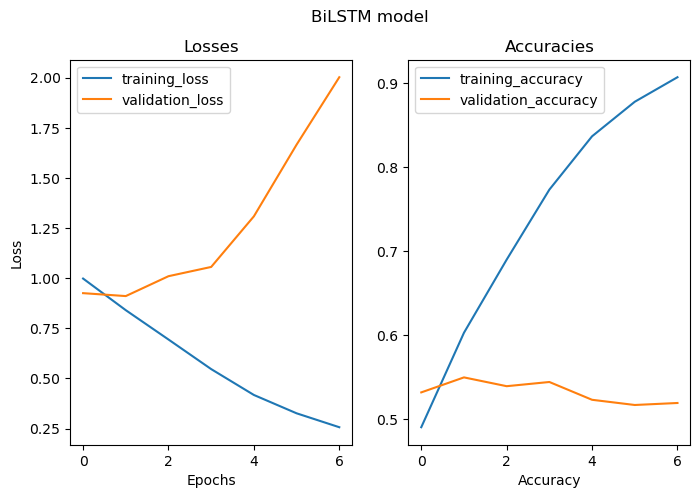

In [42]:
# Use the best parameters to train the model
# Hardcoded here from previous run for reproducibility
num_units_1 = 256
num_units_2 = 100
dropout = 0.2
embedding_dim = 256
num_units_3 = 10

# with strategy.scope():       # for TPU
with tf.device(device):
  model2 = Sequential()
  model2.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model2.add(Bidirectional(LSTM(num_units_1, return_sequences=False)))
  model2.add(Dense(num_units_2, activation="relu"))
  # model2.add(BatchNormalization())
  model2.add(Dense(num_units_3, activation="relu"))
  # model2.add(BatchNormalization())
  model2.add(Dropout(dropout))
  model2.add(Dense(num_classes, activation="sigmoid"))

  model2.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model2.summary()

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("bilstm_model",save_best_only=True)

history2 = model2.fit(
    training_padded,
    y_train,
    epochs=num_epochs,
    validation_data=(val_padded, y_val),
    callbacks=[early_stop, checkpoint_cb],
    verbose=2,
)

# Plot the curves
plot_curves(history2, 'BiLSTM model')

In [43]:
# evaluate on test data
y_pred = model2.predict(test_padded)
y_pred = np.argmax(y_pred, axis=1)
print(f"BiLSTM model f1 score: {f1_score(y_test, y_pred, average='macro')}")

132/132 [==============================] - 3s 20ms/step
BiLSTM model f1 score: 0.5393994874317797


#### Fast Text
Preprocessing text

In [44]:
df_clean_train['fasttext'] = df_clean_train.apply(lambda row: f"__label__{row['label']} {row['text']}", axis=1)

# Data splits
# -------------
# split the data into train, validation and test sets
seed1 = 42
seed2 = 52
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(df_clean_train['fasttext'], df_clean_train['label'], test_size=0.2, random_state=seed1)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=X_test.shape[0], random_state=seed2)

X_train_and_val.to_csv("train_and_val_fasttext.txt",columns=['fasttext'], index=False, header=False)
X_train.to_csv("train_fasttext.txt",columns=['fasttext'], index=False, header=False)
X_val.to_csv("val_fasttext.txt",columns=['fasttext'], index=False, header=False)
X_test.to_csv("test_fasttext.txt",columns=['fasttext'], index=False, header=False)

X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(df_clean_train['lemmatized_sentence'], df_clean_train['label'], test_size=0.2, random_state=seed1)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=X_test.shape[0], random_state=seed2)
X_train_and_val.to_csv("train_and_val_fasttext_embedding.txt",columns=['lemmatized_sentence'], index=False, header=False)
X_train.to_csv("train_fasttext_embedding.txt",columns=['lemmatized_sentence'], index=False, header=False)
X_val.to_csv("val_fasttext_embedding.txt",columns=['lemmatized_sentence'], index=False, header=False)
X_test.to_csv("test_fasttext_embedding.txt",columns=['lemmatized_sentence'], index=False, header=False)

With Default Config

In [6]:
import fasttext


In [45]:
def print_f1(results):
    # calculate f1 score from the results
    precision = results[1]
    recall = results[2]
    f1 = 2 * (precision * recall) / (precision + recall)
    print(f"FastText model f1 score: {f1}")

model_ft = fasttext.train_supervised(input="train_fasttext.txt")
model_ft.save_model("model_beer_1.bin")
results = model_ft.test("test_fasttext.txt")
print_f1(results)

FastText model f1 score: 0.5375375375375375


With Autotuner

In [46]:
model_ft = fasttext.train_supervised(input="train_fasttext.txt", 
                                    # epoch=25, 
                                    # # lr=1.0, 
                                    # wordNgrams=3, 
                                    # bucket=200000, 
                                    # dim=50,
                                    # loss='hs',
                                    autotuneValidationFile="val_fasttext.txt"
                                    )
model_ft.save_model("model_beer_2.bin")
results = model_ft.test("test_fasttext.txt")
print_f1(results)

FastText model f1 score: 0.5585585585585585


Learning Fasttext Embeddings

In [7]:
embedding_model = fasttext.train_unsupervised('train_and_val_fasttext_embedding.txt', minn=2, maxn=5, dim=100)

In [8]:
# generate embeddings for the reviews
train_embeddings = []
df_train_embeddings = pd.read_csv("train_fasttext_embedding.txt", header=None)
df_train_embeddings.columns = ['text_clean']
for review in df_train_embeddings['text_clean']:
    embedding = embedding_model.get_sentence_vector(review)
    train_embeddings.append(embedding)

val_embeddings = []
df_val_embeddings = pd.read_csv("val_fasttext_embedding.txt", header=None)
df_val_embeddings.columns = ['text_clean']
for review in df_val_embeddings['text_clean']:
    embedding = embedding_model.get_sentence_vector(review)
    val_embeddings.append(embedding)

# convert the embeddings to numpy arrays
X_train_fasttext = np.array(train_embeddings)
y_train_fasttext = y_train
X_val_fasttext = np.array(val_embeddings)
y_val_fasttext = y_val

X_train_fasttext = tf.expand_dims(X_train_fasttext, axis=-1)
X_val_fasttext = tf.expand_dims(X_val_fasttext, axis=-1)

In [9]:
# Apply bilstm on this embedding vector
# Use the best parameters to train the model
# Hardcoded here from previous run for reproducibility
num_units_1 = 64
num_units_2 = 128
dropout = 0.2
num_units_3 = 64
num_classes = 3

# with strategy.scope():       # for TPU
with tf.device('/GPU:0'):
  model_ft_custom = Sequential()
  model_ft_custom.add(Input(shape=(100,1)))
  model_ft_custom.add(Bidirectional(LSTM(num_units_1, return_sequences=False)))
  model_ft_custom.add(Dense(num_units_2, activation="relu"))
  model_ft_custom.add(Dense(num_units_3, activation="relu"))
  model_ft_custom.add(Dropout(dropout))
  model_ft_custom.add(Dense(num_classes, activation="sigmoid"))

  model_ft_custom.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model_ft_custom.summary()

num_epochs = 60
early_stop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("bilstm_model",save_best_only=True)

history_ft_custom = model_ft_custom.fit(
    X_train_fasttext,
    y_train,
    epochs=num_epochs,
    validation_data=(X_val_fasttext, y_val),
    callbacks=[early_stop, checkpoint_cb],
    verbose=2,
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              33792     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 58,755
Trainable params: 58,755
Non-trainable params: 0
____________________________________________________

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 20s - loss: 1.0944 - accuracy: 0.3614 - val_loss: 1.0882 - val_accuracy: 0.3666 - 20s/epoch - 52ms/step
Epoch 2/60
395/395 - 6s - loss: 1.0724 - accuracy: 0.4029 - val_loss: 1.0945 - val_accuracy: 0.3652 - 6s/epoch - 15ms/step
Epoch 3/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 14s - loss: 1.0464 - accuracy: 0.4370 - val_loss: 1.0662 - val_accuracy: 0.4260 - 14s/epoch - 34ms/step
Epoch 4/60
395/395 - 6s - loss: 1.0382 - accuracy: 0.4515 - val_loss: 1.0711 - val_accuracy: 0.4132 - 6s/epoch - 16ms/step
Epoch 5/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 14s - loss: 1.0271 - accuracy: 0.4632 - val_loss: 1.0267 - val_accuracy: 0.4666 - 14s/epoch - 36ms/step
Epoch 6/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 15s - loss: 1.0253 - accuracy: 0.4633 - val_loss: 1.0180 - val_accuracy: 0.4730 - 15s/epoch - 39ms/step
Epoch 7/60
395/395 - 6s - loss: 1.0179 - accuracy: 0.4709 - val_loss: 1.0332 - val_accuracy: 0.4386 - 6s/epoch - 16ms/step
Epoch 8/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 13s - loss: 1.0090 - accuracy: 0.4810 - val_loss: 1.0068 - val_accuracy: 0.5032 - 13s/epoch - 34ms/step
Epoch 9/60
395/395 - 6s - loss: 1.0063 - accuracy: 0.4777 - val_loss: 1.0069 - val_accuracy: 0.4951 - 6s/epoch - 15ms/step
Epoch 10/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 13s - loss: 0.9922 - accuracy: 0.4950 - val_loss: 0.9949 - val_accuracy: 0.5068 - 13s/epoch - 32ms/step
Epoch 11/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 13s - loss: 0.9900 - accuracy: 0.4953 - val_loss: 0.9910 - val_accuracy: 0.5015 - 13s/epoch - 32ms/step
Epoch 12/60
395/395 - 6s - loss: 0.9799 - accuracy: 0.5044 - val_loss: 1.0077 - val_accuracy: 0.4775 - 6s/epoch - 15ms/step
Epoch 13/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 13s - loss: 0.9787 - accuracy: 0.5042 - val_loss: 0.9784 - val_accuracy: 0.5167 - 13s/epoch - 34ms/step
Epoch 14/60
395/395 - 5s - loss: 0.9759 - accuracy: 0.5061 - val_loss: 0.9818 - val_accuracy: 0.5063 - 5s/epoch - 14ms/step
Epoch 15/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 13s - loss: 0.9609 - accuracy: 0.5192 - val_loss: 0.9641 - val_accuracy: 0.5234 - 13s/epoch - 32ms/step
Epoch 16/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 14s - loss: 0.9505 - accuracy: 0.5300 - val_loss: 0.9482 - val_accuracy: 0.5331 - 14s/epoch - 36ms/step
Epoch 17/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 14s - loss: 0.9440 - accuracy: 0.5346 - val_loss: 0.9439 - val_accuracy: 0.5348 - 14s/epoch - 36ms/step
Epoch 18/60
395/395 - 6s - loss: 0.9304 - accuracy: 0.5427 - val_loss: 0.9613 - val_accuracy: 0.5158 - 6s/epoch - 15ms/step
Epoch 19/60
395/395 - 6s - loss: 0.9261 - accuracy: 0.5423 - val_loss: 0.9717 - val_accuracy: 0.5260 - 6s/epoch - 16ms/step
Epoch 20/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 14s - loss: 0.9263 - accuracy: 0.5444 - val_loss: 0.9359 - val_accuracy: 0.5415 - 14s/epoch - 35ms/step
Epoch 21/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 15s - loss: 0.9230 - accuracy: 0.5472 - val_loss: 0.9273 - val_accuracy: 0.5476 - 15s/epoch - 39ms/step
Epoch 22/60
395/395 - 6s - loss: 0.9229 - accuracy: 0.5466 - val_loss: 0.9290 - val_accuracy: 0.5327 - 6s/epoch - 15ms/step
Epoch 23/60
395/395 - 6s - loss: 0.9120 - accuracy: 0.5515 - val_loss: 0.9290 - val_accuracy: 0.5346 - 6s/epoch - 15ms/step
Epoch 24/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 13s - loss: 0.9101 - accuracy: 0.5512 - val_loss: 0.9214 - val_accuracy: 0.5448 - 13s/epoch - 33ms/step
Epoch 25/60
395/395 - 6s - loss: 0.9046 - accuracy: 0.5584 - val_loss: 0.9379 - val_accuracy: 0.5400 - 6s/epoch - 15ms/step
Epoch 26/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 12s - loss: 0.9045 - accuracy: 0.5636 - val_loss: 0.9180 - val_accuracy: 0.5464 - 12s/epoch - 31ms/step
Epoch 27/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 13s - loss: 0.9024 - accuracy: 0.5568 - val_loss: 0.9162 - val_accuracy: 0.5519 - 13s/epoch - 33ms/step
Epoch 28/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 13s - loss: 0.8944 - accuracy: 0.5697 - val_loss: 0.9103 - val_accuracy: 0.5422 - 13s/epoch - 33ms/step
Epoch 29/60
395/395 - 6s - loss: 0.8961 - accuracy: 0.5623 - val_loss: 0.9311 - val_accuracy: 0.5396 - 6s/epoch - 16ms/step
Epoch 30/60
395/395 - 6s - loss: 0.8924 - accuracy: 0.5639 - val_loss: 0.9162 - val_accuracy: 0.5472 - 6s/epoch - 15ms/step
Epoch 31/60
395/395 - 6s - loss: 0.8961 - accuracy: 0.5667 - val_loss: 0.9215 - val_accuracy: 0.5422 - 6s/epoch - 14ms/step
Epoch 32/60
395/395 - 6s - loss: 0.8876 - accuracy: 0.5716 - val_loss: 0.9110 - val_accuracy: 0.5526 - 6s/epoch - 15ms/step
Epoch 33/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 13s - loss: 0.8885 - accuracy: 0.5653 - val_loss: 0.9096 - val_accuracy: 0.5541 - 13s/epoch - 32ms/step
Epoch 34/60
395/395 - 6s - loss: 0.8873 - accuracy: 0.5713 - val_loss: 0.9099 - val_accuracy: 0.5522 - 6s/epoch - 15ms/step
Epoch 35/60
395/395 - 6s - loss: 0.8862 - accuracy: 0.5702 - val_loss: 0.9165 - val_accuracy: 0.5481 - 6s/epoch - 14ms/step
Epoch 36/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 13s - loss: 0.8835 - accuracy: 0.5703 - val_loss: 0.9025 - val_accuracy: 0.5579 - 13s/epoch - 34ms/step
Epoch 37/60
395/395 - 6s - loss: 0.8847 - accuracy: 0.5738 - val_loss: 0.9101 - val_accuracy: 0.5541 - 6s/epoch - 15ms/step
Epoch 38/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 13s - loss: 0.8808 - accuracy: 0.5721 - val_loss: 0.9009 - val_accuracy: 0.5543 - 13s/epoch - 33ms/step
Epoch 39/60
395/395 - 6s - loss: 0.8762 - accuracy: 0.5739 - val_loss: 0.9218 - val_accuracy: 0.5476 - 6s/epoch - 15ms/step
Epoch 40/60
395/395 - 6s - loss: 0.8725 - accuracy: 0.5752 - val_loss: 0.9045 - val_accuracy: 0.5595 - 6s/epoch - 15ms/step
Epoch 41/60
395/395 - 6s - loss: 0.8740 - accuracy: 0.5776 - val_loss: 0.9080 - val_accuracy: 0.5533 - 6s/epoch - 16ms/step
Epoch 42/60
395/395 - 6s - loss: 0.8736 - accuracy: 0.5771 - val_loss: 0.9124 - val_accuracy: 0.5626 - 6s/epoch - 14ms/step
Epoch 43/60


INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


395/395 - 13s - loss: 0.8726 - accuracy: 0.5778 - val_loss: 0.8988 - val_accuracy: 0.5633 - 13s/epoch - 34ms/step
Epoch 44/60
395/395 - 7s - loss: 0.8693 - accuracy: 0.5770 - val_loss: 0.9181 - val_accuracy: 0.5583 - 7s/epoch - 17ms/step
Epoch 45/60
395/395 - 6s - loss: 0.8689 - accuracy: 0.5794 - val_loss: 0.9046 - val_accuracy: 0.5588 - 6s/epoch - 14ms/step
Epoch 46/60
395/395 - 5s - loss: 0.8689 - accuracy: 0.5806 - val_loss: 0.9168 - val_accuracy: 0.5631 - 5s/epoch - 14ms/step
Epoch 47/60
395/395 - 5s - loss: 0.8700 - accuracy: 0.5798 - val_loss: 0.9138 - val_accuracy: 0.5636 - 5s/epoch - 13ms/step
Epoch 48/60
395/395 - 5s - loss: 0.8637 - accuracy: 0.5870 - val_loss: 0.9042 - val_accuracy: 0.5524 - 5s/epoch - 14ms/step


In [10]:
# generate embedding for the test data
test_embeddings = []
df_test_embeddings = pd.read_csv("test_fasttext_embedding.txt", header=None)
df_test_embeddings.columns = ['text_clean']
for review in df_test_embeddings['text_clean']:
    embedding = embedding_model.get_sentence_vector(review)
    test_embeddings.append(embedding)

X_test_fasttext = np.array(test_embeddings)
y_test_fasttext = y_test

X_test_fasttext = tf.expand_dims(X_test_fasttext, axis=-1)

# compute f1 score
y_pred = model_ft_custom.predict(X_test_fasttext)
y_pred = np.argmax(y_pred, axis=1)
print(f"BiLSTM model with custom Fast Text embeddings f1 score: {f1_score(y_test, y_pred, average='macro')}")

132/132 [==============================] - 1s 7ms/step
BiLSTM model with custom Fast Text embeddings f1 score: 0.5641275698496332
